In [1]:
import tensorflow as tf

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from PIL import Image
import random


import tifffile as tiff
import os
from skimage.io import imread, imshow,imsave
from skimage.transform import resize
import albumentations as A #use this instead of keras imagegenerator

from tqdm import tqdm 

In [2]:
images_path='../input/hubmap-organ-segmentation/train_images'
masks_path='../input/raw-mask/masks'
test_img_path='../input/hubmap-organ-segmentation/test_images'

In [3]:
SIZE=256
X_train=[]


images = sorted(os.listdir(images_path)) 
# add patched image
for i, image_name in tqdm(enumerate(images),total=len(images)):    
    if (image_name.split('.')[1] == 'tiff'):
        #print(image_directory+image_name)
        #image = tiff.imread(patches_img_path+'/'+ image_name)
        image = cv2.imread(images_path+'/'+image_name, 1)
        #image = Image.fromarray(image)
        
        image = resize(image,(SIZE, SIZE), mode='edge', anti_aliasing=False, 
                               anti_aliasing_sigma=None,
                               preserve_range=True,order=0)
        #image = image.squeeze()
        X_train.append(np.array(image,dtype='uint8'))


100%|██████████| 351/351 [01:43<00:00,  3.40it/s]


In [4]:
X_train=np.array(X_train)       #dtype = uint8 ,X_train.nbytes= 552075264 8times smaller than float 64
#normalize X_train
#X_train=X_train/255.  # float 64 X_train.nbytes= 4416602112
print(X_train.min(),X_train.max()) 

0 255


In [5]:
# create mask dataset
# add patched mask
SIZE=256

Y_train=[]

masks = sorted(os.listdir(masks_path))
for i, mask_name in tqdm(enumerate(masks),total=len(masks)):
    if (mask_name.split('.')[1] == 'tiff'):
        #image = tiff.imread(patches_msk_path+'/'+mask_name)
        mask = cv2.imread(masks_path+'/'+mask_name, 0)
        #image = Image.fromarray(image)
        mask = resize(mask,(SIZE, SIZE), mode='edge', anti_aliasing=False, 
                               anti_aliasing_sigma=None,
                               preserve_range=True,order=0)
        Y_train.append(np.array(mask))

100%|██████████| 351/351 [00:14<00:00, 25.07it/s]


In [6]:
#Y_train=np.array(Y_train,dtype='float32')
#Y_train=np.array(Y_train,dtype='float64') 
Y_train=np.array(Y_train,dtype='uint8') 

In [7]:
#normalize 
#Y_train = Y_train/255.
#expand Y_train dimension
Y_train = np.expand_dims(Y_train, axis=3)
print(np.unique(Y_train))
print(Y_train.shape)
print(X_train.shape)
print(X_train.dtype)
print(Y_train.dtype)

[0 1]
(351, 256, 256, 1)
(351, 256, 256, 3)
uint8
uint8


307


/opt/conda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


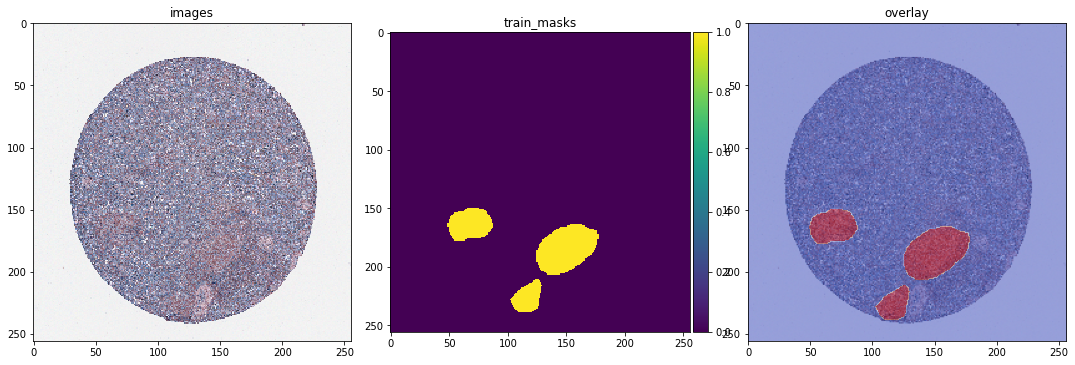

In [8]:
#import random
number=random.randint(0,len(X_train))

print(number)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("images")
imshow(X_train[number])
plt.subplot(1,3,2)
plt.title("train_masks")
imshow(Y_train[number])
plt.subplot(1,3,3)
plt.title("overlay")
plt.imshow(X_train[number])
plt.imshow(Y_train[number], cmap='coolwarm', alpha=0.5)

In [9]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 0)




In [10]:
print('X_test shpae',X_test.shape)
print('Y_test shpae',Y_test.shape)

print('X_train shpae',X_train.shape)
print('Y_train shpae',Y_train.shape)



X_test shpae (36, 256, 256, 3)
Y_test shpae (36, 256, 256, 1)
X_train shpae (315, 256, 256, 3)
Y_train shpae (315, 256, 256, 1)


In [11]:

"""
Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf
Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)
Note: Batch normalization should be performed over channels after a convolution, 
In the following code axis is set to 3 as our inputs are of shape 
[None, height, width, channel]. Channel is axis=3.
Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)




def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2.(choose this version) conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn





def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model



In [14]:
import gc
del masks, images
gc.collect()

23

In [15]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers




#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
#from focal_loss import BinaryFocalLoss

###############################################################################


#Try various models: Unet, Attention_UNet, and Attention_ResUnet
#Rename original python file from 224_225_226_models.py to models.py


#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 
filepath="/kaggle/working/custom_att_res_unet_no_patch-{epoch:02d}-{val_dice_coef:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
#log_csv = CSVLogger('my_logs_no_patch.csv', separator=',', append=False)

callbacks_list = [checkpoint]



#___________________________________________
'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=dice_coef_loss, 
              metrics=dice_coef)


# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())

Y_train=np.array(Y_train,dtype='float32')
Y_test=np.array(Y_test,dtype='float32')
start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, Y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, Y_test ), 
                                              callbacks=callbacks_list,
                                            
                    shuffle=False,
                    epochs=200)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

#att_res_unet_model.save('AttResUnet_no_aug_50epochs_B_focal.hdf5')




2022-08-28 12:59:00.498004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 12:59:00.600260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 12:59:00.601095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 12:59:00.602836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
___________________________________________________________________________________

2022-08-28 12:59:02.792767: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82575360 exceeds 10% of free system memory.
2022-08-28 12:59:02.918583: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 61931520 exceeds 10% of free system memory.
2022-08-28 12:59:02.967989: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 82575360 exceeds 10% of free system memory.
2022-08-28 12:59:03.063700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-08-28 12:59:09.542691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 [==============================] - 36s 518ms/step - loss: -0.2373 - dice_coef: 0.2391 - val_loss: -2.4046e-05 - val_dice_coef: 2.5423e-05

Epoch 00001: val_dice_coef improved from -inf to 0.00003, saving model to /kaggle/working/custom_att_res_unet_no_patch-01-0.00.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-08-28 12:59:39.439892: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


Epoch 2/200
40/40 [==============================] - 16s 404ms/step - loss: -0.2845 - dice_coef: 0.2862 - val_loss: -0.1765 - val_dice_coef: 0.1773

Epoch 00002: val_dice_coef improved from 0.00003 to 0.17734, saving model to /kaggle/working/custom_att_res_unet_no_patch-02-0.18.hdf5
Epoch 3/200
40/40 [==============================] - 16s 406ms/step - loss: -0.3306 - dice_coef: 0.3326 - val_loss: -0.1750 - val_dice_coef: 0.1758

Epoch 00003: val_dice_coef did not improve from 0.17734
Epoch 4/200
40/40 [==============================] - 16s 402ms/step - loss: -0.3785 - dice_coef: 0.3806 - val_loss: -0.1835 - val_dice_coef: 0.1844

Epoch 00004: val_dice_coef improved from 0.17734 to 0.18442, saving model to /kaggle/working/custom_att_res_unet_no_patch-04-0.18.hdf5
Epoch 5/200
40/40 [==============================] - 16s 406ms/step - loss: -0.4069 - dice_coef: 0.4091 - val_loss: -0.1762 - val_dice_coef: 0.1767

Epoch 00005: val_dice_coef did not improve from 0.18442
Epoch 6/200
40/40 [===

In [16]:
att_res_unet_model.save('/kaggle/working/AttResUnet_no_aug_50epochs_B_focal.hdf5')


In [ ]:
#os.remove("./custom_att_res_unet_no_patch-04-0.19.hdf5")

# Load Model

In [19]:
from keras.models import load_model
model1= load_model('./custom_att_res_unet_no_patch-198-0.70.hdf5',
                       custom_objects={'dice_coef':dice_coef,
                                      'dice_coef_loss':dice_coef_loss
                                       })

# Test Time augmentation

In [21]:
#Now that we know the transformations are working, let us extend to all predictions
predictions1 = []
for image in X_test:
    
    pred_original = model1.predict(np.expand_dims(image, axis=0))[0][:, :, 0]
    
    pred_lr = model1.predict(np.expand_dims(np.fliplr(image), axis=0))[0][:, :, 0]
    pred_lr = np.fliplr(pred_lr)
    
    pred_ud = model1.predict(np.expand_dims(np.flipud(image), axis=0))[0][:, :, 0]
    pred_ud = np.flipud(pred_ud)
    
    pred_lr_ud = model1.predict(np.expand_dims(np.fliplr(np.flipud(image)), axis=0))[0][:, :, 0]
    pred_lr_ud = np.fliplr(np.flipud(pred_lr_ud))
    
    preds = (pred_original + pred_lr + pred_ud + pred_lr_ud) / 4
    
    predictions1.append(preds)


predictions1 = np.array(predictions1)

threshold = 0.5
predictions_th1 = predictions1 > threshold



1


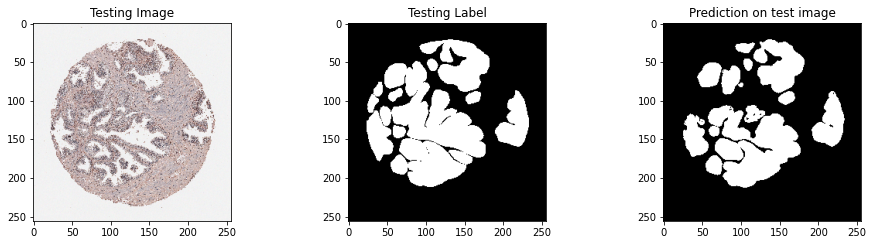

In [29]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)

print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = predictions_th1[test_img_number]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()